# Project : Communicate Data Findings

## Part I: Exploratory Data Analysis

Submitted by: Suraj Gurav

**Dataset: Ford GoBike System Data**

The required dataset is obtained from the [Source](https://s3.amazonaws.com/baywheels-data/index.html)

Here the monthwise data is available starting from January 2018 to May 2020. However, everything is updated on 10th Jan 2020. Going through some of the _.csv_ files manually, I found that most of the data is missing from some files.

Hence, the selected data for this project is only **from January 2018 to March 2018**.

Exploratory data analysis is performed with this **outline**

1. [Data Gathering](#Data-Gathering)
2. [Data Assessment](#Data-Assessment)
3. [Data Cleaning](#Data-Cleaning)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis-and-Visualization)
5. [Univariate Exploration](#2.-Univariate-Exploration)
6. [Bivariate Exploration](#3.-Bivariate-Exploration)
7. [Multivariate Exploration](#4.-Multivariate-Exploration)
8. [Conclusion](#Conclusion)

**Import required libraries**

In [8]:
#Import important libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
from sklearn.cluster import KMeans
import zipfile
%matplotlib inline

print("All Libraries Imported !!!")

All Libraries Imported !!!


### Data Wrangling

All the steps of data wrangling are demonstrated as follows.

#### Data Gathering

As a first step in data wrangling, we first need to collect the data from the [Source](https://s3.amazonaws.com/baywheels-data/index.html). The monthly data is available in the form of _.zip_ files.

The code below will download, unzip and merge the data together to a final *.csv file

As mentioned earlier data only for first three months of year 2018 will be downloaded and used for the project.

> This step includes automatic download of data, manually moving it to new folder and then automatic unzip it.
Hence, it is given as markdown.

However, the instructions are written clearly to implement below code cells. The further code after unzipping the files can be executed as usual.

<code>
year_data = [x for x in range(201801, 201813)]
for year in year_data[:3]:
    url = f"https://s3.amazonaws.com/fordgobike-data/{year}-fordgobike-tripdata.csv.zip"
    response = requests.get(url)
    #save file
    with open(f"{year}-fordgobike-tripdata.csv.zip", mode = "wb") as file:
        file.write(response.content)

</code>

After downloading the .zip files, manually move the files to new folder called as _Data_ within the folder where this script is running.

Unzipping the files using <code>zipfile</code> library

<code>
#https://stackoverflow.com/questions/3451111/unzipping-files-in-python/3451150
files = [x for x in os.walk("./Data")][0][2] # accessing all file names and making a list
for x in files:
    if ".zip" in x:
        with zipfile.ZipFile(f"./Data/{x}",'r') as zip_ref:
            zip_ref.extractall("./Data")
            

</code>

If you downloaded and manually unzipped the data, then keep the excel file in the new folder called as _Data_ within the base directory for this notebook.

After unzipping, in this step, all the _.csv_ files will be accessed one by one and clubbed to a single _.csv_ file called as <code>ford_gobike_data.csv</code>

In [11]:
files = [x for x in os.walk("./Data")][0][2]
month_list =  [int(x[:6]) for x in files if ".zip" not in x] # listing first three the months in year 2018 from extracted files

ford_gobike_data = pd.read_csv(f"./Data/{month_list[0]}-fordgobike-tripdata.csv") # read the first file
len_df = len(ford_gobike_data)

#loop over all files and append data one by one
for i, month in enumerate(month_list):
    
    if i+2 > len(month_list):
        break
    
    else:    
        df_append  = pd.read_csv(f"./Data/{month_list[i+1]}-fordgobike-tripdata.csv")
        len_df += len(df_append)
        assert all(ford_gobike_data.columns == df_append.columns)
        ford_gobike_data = ford_gobike_data.append(df_append)
        print(f"{month_list[i+1]}")
        
ford_gobike_data.to_csv("ford_gobike_data.csv", index = False)
print("ford_gobike_data.csv is generated !!!")           
print(len_df == len(ford_gobike_data)) # This is the check -- it must be True to ensure all data from dataframe is added to ford_gobike_data.csv
del len_df, df_append, ford_gobike_data, files, month_list

201802
201803
ford_gobike_data1.csv is generated !!!
True


#### Data Assessment

In this section, I will go through the data to check for its quality, tidiness and dimensions. Both, programmatic as well as visual assessment techniques are demonstrated.

Hence, the <code>ford_gobike_data.csv</code> generated at the end of data gathering process will be imported and stored to dataframe <code>df</code>

In [ ]:
df = pd.read_csv(r"./Data/ford_gobike_data.csv")
df.head()

Check the total number of rows and columns in the dataframe

In [ ]:
row, column = df.shape
print(f"ford_gobike_data.csv contains {row} rows and {column} columns")

__1. Check for data type__

All the columns and their datatypes can be checked with <code>df.info()</code>

In [ ]:
df.info()

Clearly, the data type for columns _start_time_ and _end_time_ is not datetime. 

Also, the _member_birth_year_ can not be a float64, it should be integer

However, no rigid information about the datatype of _start_station_id, end_station_id_ and _bike_id_ is available at the [Source Repository](https://github.com/NABSA/gbfs/blob/master/gbfs.md). Let's us assume the data type for these columns be _int64_

__2. Check for missing values__

In [ ]:
fig, ax = plt.subplots(figsize = (25,7))
ax = sns.heatmap(df.isnull(), vmin = 0, vmax = 1)

above visual assessment shows that, all columns except _member_birth_year_ and _member_gender_ have missing values. 

In [ ]:
df[df.member_birth_year.isnull()].head(10)

However from above programmatic and visual assessment, these missing values belong to same rows. 

In [ ]:
print(f"Total {len(df[df.member_birth_year.isnull()])} values are missing from member_birth_year column")

__3. Check for most common star and end station coordinates__

In [ ]:
df.start_station_latitude.value_counts()

In [ ]:
df.start_station_longitude.value_counts()

In [ ]:
df.start_station_name.value_counts()

In [ ]:
fig, ax = plt.subplots(figsize = (25,7))
sns.scatterplot(data = df.sample(50000, random_state = 5), x = "start_station_longitude", y = "start_station_latitude", alpha = 0.15, s = 200)
plt.xlim(df.start_station_longitude.min(),df.start_station_longitude.max())
plt.ylim(df.start_station_latitude.min(),df.start_station_latitude.max())
plt.title(" Start Station Coordinates ");

Most frequent __start station coordinates__ are __37.795392 latitude__ and __-122.394203 longitude__ with __San Francisco Ferry Building (Harry Bridges Plaza)__ being the most frequent start station

In [ ]:
df.end_station_latitude.value_counts()

In [ ]:
df.end_station_longitude.value_counts()

In [ ]:
df.end_station_name.value_counts()

In [ ]:
fig, ax = plt.subplots(figsize = (25,7))
sns.scatterplot(data = df.sample(50000, random_state = 5), x = "end_station_longitude", y = "end_station_latitude", alpha = 0.15, s = 200)
plt.xlim(df.end_station_longitude.min(),df.end_station_longitude.max())
plt.ylim(df.end_station_latitude.min(),df.end_station_latitude.max())
plt.title(" End Station Coordinates ");

Most frequent __end station coordinates__ are __37.776598 latitude__ and __-122.395282 longitude__ with __San Francisco Caltrain (Townsend St at 4th St)__ being the most common end station.

Looks like clusters of start and end station coordinates are present in the dataset.

__4. Check Uniqueness of _start_station_id_ and _end_station_id___

In [ ]:
df_names = df[["start_station_id", "start_station_name", "start_station_latitude", "start_station_longitude"]].copy()
df_names.sample(5)

In [ ]:
df_names.shape

In [ ]:
df_names.drop_duplicates(inplace=True)
df_names.sort_values("start_station_id", inplace=True)
df_names.reset_index(inplace=True)
print(f"This dataframe contains {df_names.shape[0]} rows and {df_names.shape[1]} columns")
df_names.tail()      

Hence, there are 290 unique start station names. Now let us check if two different names belong to same _start_station_id_. If the all the values in _start_station_id_ column are unique i.e. one id belongs to exactly one _start_station_name_ then the output of below cell must be a null series.

In [ ]:
df_names.start_station_id.value_counts()[df_names.start_station_id.value_counts()>1]

The uniqueness of the _end_station_id_ can also be checked in the same fashion.

In [ ]:
del df_names
df_names = df[["end_station_id", "end_station_name", "end_station_latitude", "end_station_longitude"]].copy()
df_names.sample(5)

In [ ]:
df_names.drop_duplicates(inplace=True)
df_names.sort_values("end_station_id", inplace=True)
df_names.reset_index(inplace=True)
print(f"This dataframe contains {df_names.shape[0]} rows and {df_names.shape[1]} columns, hence there are {df_names.shape[0]} unique end station names")
df_names.tail() 

In [ ]:
df_names.end_station_id.value_counts()[df_names.end_station_id.value_counts()>1]

The output of above cell as empty series proves that, one _end_station_id_ belongs to exactly one _end_station_name_

__5. Check statistics__

In [ ]:
df.describe()

Everything looks normal with the statistics, except with the duration_sec. The maximum value of 86366 sec in _duration_sec_ column denotes the presence of outlier in this column.

In [ ]:
df[df["duration_sec"]>43200.00].info() # 12 hours = 43200 seconds

Total 296 times the bike share duration was more that 43200 seconds or 12 hours. This might have happened due to either people forget to unregister the already shared bike or they really shared bike for a whole day. However, no robust information is available about such usage.

Secondly, almost 45% of these bike shares have missing values in _member_birth_year_ column

__Assessment Summary__

The whole Data Assessment Efforts can be summarised with the below mentioned quality and tidiness issues

* __Quality__

    1. The data type for columns start_time and end_time is not datetime.
    2. The data type for member_birth_year is not integer
    3. No reliable information about the datatype of start_station_id, end_station_id and bike_id is available at the [Source Repository](https://github.com/NABSA/gbfs/blob/master/gbfs.md).
    4. Total 24966 values are missing from member_birth_year and member_gender column


* __Tidiness__

Tidiness issue show how messy the given dataset is. However, no tidiness errors are observed in this data.

### Data Cleaning

All the quality and tidiness issues were kept in mind to perform data cleaning operations. This data cleaning process followed this sequence.

First of all, let us make a copy of this dataframe and call it as <code>df_clean</code>. All the data cleaning operations will be performed on this newly created dataframe.

In [ ]:
df_clean = df.copy()
df_clean.shape

_**1. Handling Missing Values**_

__Define__:

To drop the rows having missing values in member_birth_year column

__Code__:

In [ ]:
df_clean.dropna(subset = ["member_birth_year"], inplace = True)

__Test__:

Let us check if all the missing values are dropped or not.
This can be done programmatically using <code>.info()</code> method and can be visualized with <code>heatmap</code>

In [ ]:
df_clean.info()

In [ ]:
fig, ax = plt.subplots(figsize = (25,7))
ax = sns.heatmap(df_clean.isnull(), vmin = 0, vmax = 1)

Looks nice !!! We now have eliminated all the rows with missing values.

_**2. Correcting the datatype**_

__Define__:

To make the data type for columns start_time and end_time as datetime. To correct the datatype for member_birth_year and make it as int64

__Code__:

In [ ]:
df_clean["start_time"] = pd.to_datetime(df_clean.start_time)
df_clean["end_time"] = pd.to_datetime(df_clean.end_time)
for x in ["member_birth_year"]:
    df_clean[x] = df_clean[x].astype("int64")

__Test__:

Checking the corrected data types using <code>.info()</code> method

In [ ]:
df_clean.info()

_**3. Correcting the index**_

as seen in the _test_ part of the previous step, the total rows are 287936 but the index ranges from 0 to 312901.

__Define__:

To reset the index to match the length of this cleaned dataframe.

__Code__:

In [ ]:
df_clean.reset_index(inplace=True, drop=True)

__Test__:
    
Check if the changes were applied or not using <code>.info()</code> method

In [ ]:
df_clean.info()

__Store this cleaned dataset__

This cleaned dataset will be now stored to a new _.csv_ file called as <code>ford_gobike_data_clean.csv</code>

In [ ]:
df_clean.to_csv("ford_gobike_data_clean.csv", index=False)
print("This cleaned dataset csv file is now Generated !!!")

---------------------------------------------------------------------------------------------

### Exploratory Data Analysis and Visualization

Now, as the data wrangling process is completed, Exploratory Data Analysis can be used to look into the cleaned dataset to get answer for some questions regarding this data.

Let us first import the cleaned dataset into a dataframe called as <code>df</code>.

In [13]:
#del df # deleting previously used dataframe
df = pd.read_csv(r"./Data/ford_gobike_data_clean.csv")
df.shape

(287936, 16)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287936 entries, 0 to 287935
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             287936 non-null  int64  
 1   start_time               287936 non-null  object 
 2   end_time                 287936 non-null  object 
 3   start_station_id         287936 non-null  int64  
 4   start_station_name       287936 non-null  object 
 5   start_station_latitude   287936 non-null  float64
 6   start_station_longitude  287936 non-null  float64
 7   end_station_id           287936 non-null  int64  
 8   end_station_name         287936 non-null  object 
 9   end_station_latitude     287936 non-null  float64
 10  end_station_longitude    287936 non-null  float64
 11  bike_id                  287936 non-null  int64  
 12  user_type                287936 non-null  object 
 13  member_birth_year        287936 non-null  int64  
 14  memb

As _read_csv_ method infer the datatypes in _.csv_ files automatically, the data type for start_time and end_time columns are again inferred incorrectly. Hence, we change the these datatypes again to _datetime_

In [15]:
df["start_time"] = pd.to_datetime(df.start_time)
df["end_time"] = pd.to_datetime(df.end_time)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287936 entries, 0 to 287935
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             287936 non-null  int64         
 1   start_time               287936 non-null  datetime64[ns]
 2   end_time                 287936 non-null  datetime64[ns]
 3   start_station_id         287936 non-null  int64         
 4   start_station_name       287936 non-null  object        
 5   start_station_latitude   287936 non-null  float64       
 6   start_station_longitude  287936 non-null  float64       
 7   end_station_id           287936 non-null  int64         
 8   end_station_name         287936 non-null  object        
 9   end_station_latitude     287936 non-null  float64       
 10  end_station_longitude    287936 non-null  float64       
 11  bike_id                  287936 non-null  int64         
 12  user_type       

Now we have all correct datatypes. let us take a overview of data using basic methods such as head(), tail(), sample(), describe() and info()

In [ ]:
df.head(3)

In [ ]:
df.tail(3)

In [ ]:
df.sample(3, random_state=5)

In [ ]:
df.describe()

In [ ]:
df.info()

### 1. Start Station Visualization

_**Question 1: In which regions do the clusters in the data are located ?**_

Let us start with visualizing the clusters of trip start stations.
Hence, Collecting the start station names along with their location coordinates to visualize these stations on map.

In [17]:
df_start = df[["duration_sec","start_station_id","start_station_name","start_station_longitude","start_station_latitude","user_type"]].copy()
df_start.head()

,duration_sec,start_station_id,start_station_name,start_station_longitude,start_station_latitude,user_type
0,75284,120,Mission Dolores Park,-122.426435,37.761420,Subscriber
1,71576,304,Jackson St at 5th St,-121.894798,37.348759,Customer
2,39966,74,Laguna St at Hayes St,-122.426244,37.776435,Subscriber
3,453,110,17th & Folsom Street Park (17th St at Folsom St),-122.415204,37.763708,Subscriber
4,180,81,Berry St at 4th St,-122.393170,37.775880,Subscriber


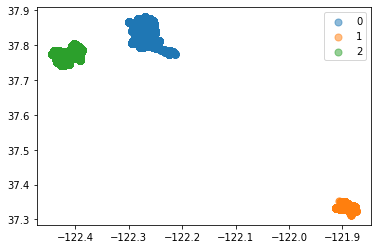

In [18]:
kmeans = KMeans(n_clusters=3).fit(df_start[["start_station_longitude", "start_station_latitude"]])
df_start["label"] = kmeans.labels_
for x in set(list(df_start.label)):
    df_plot_cluster = df_start.query(f"label == {x}")
    plt.scatter(df_plot_cluster['start_station_longitude'], df_plot_cluster["start_station_latitude"], s=50, alpha=0.5, label = x);

plt.legend();

In [19]:
df_start.sample(10)

,duration_sec,start_station_id,start_station_name,start_station_longitude,start_station_latitude,user_type,label
82257,1007,67,San Francisco Caltrain Station 2 (Townsend St...,-122.395526,37.776639,Subscriber,2
249098,863,14,Clay St at Battery St,-122.399970,37.795001,Subscriber,2
121860,354,67,San Francisco Caltrain Station 2 (Townsend St...,-122.395526,37.776639,Subscriber,2
76727,452,15,San Francisco Ferry Building (Harry Bridges Pl...,-122.394203,37.795392,Subscriber,2
216608,420,22,Howard St at Beale St,-122.394643,37.789756,Subscriber,2
13102,176,243,Bancroft Way at College Ave,-122.254337,37.869360,Subscriber,0
68372,347,62,Victoria Manalo Draves Park,-122.406432,37.777791,Subscriber,2
278695,337,140,Cesar Chavez St at Dolores St,-122.424986,37.747858,Subscriber,2
287689,1331,27,Beale St at Harrison St,-122.391865,37.788059,Subscriber,2
179785,661,71,Broderick St at Oak St,-122.439078,37.773063,Subscriber,2


In [20]:
# very large number of data points are available, hence considering random sample of 1000 data points 
locations = df_start[['start_station_latitude', 'start_station_longitude']].sample(1000, random_state=5)
locationlist = locations.values.tolist()
len(locationlist)

1000

In [21]:
# visualization on map using folium
# latitude=37.6 and longitude=-122.15 is approximate center of the map obtained from k-means clustering
bikemap = folium.Map(location=[37.6, -122.15], zoom_start=10) 
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(bikemap)
bikemap

_**Answer 1.1:**_

From above map and k-means clustering plot, I inferred following 3 regions, where the cluster in the data are located.
        
        Cluster 0 : San Franscisco
        Cluster 1 : San José
        Cluster 2 : East Bay

These lables will now be applied to original dataframe of start station co-ordinates

In [22]:
mapping = {0: "San Francisco", 1: "San José", 2: "East Bay"}
df_start["label_name"] = df_start["label"].map(mapping)
df_start.sample(10, random_state = 5)

,duration_sec,start_station_id,start_station_name,start_station_longitude,start_station_latitude,user_type,label,label_name
116210,438,296,5th St at Virginia St,-121.877120,37.325998,Subscriber,1,San José
188017,3402,16,Steuart St at Market St,-122.394430,37.794130,Customer,2,East Bay
143990,491,126,Esprit Park,-122.390648,37.761634,Subscriber,2,East Bay
286232,555,75,Market St at Franklin St,-122.421239,37.773793,Subscriber,2,East Bay
20945,263,36,Folsom St at 3rd St,-122.398870,37.783830,Subscriber,2,East Bay
243200,228,195,Bay Pl at Vernon St,-122.260779,37.812314,Subscriber,0,San Francisco
122265,1089,3,Powell St BART Station (Market St at 4th St),-122.404904,37.786375,Subscriber,2,East Bay
159635,247,176,MacArthur BART Station,-122.266315,37.828410,Subscriber,0,San Francisco
158850,1638,27,Beale St at Harrison St,-122.391865,37.788059,Subscriber,2,East Bay
123133,1267,323,Broadway at Kearny,-122.405950,37.798014,Subscriber,2,East Bay


_**Question 1.2: How many different stations are available in each of three clusters ?**_

In [ ]:
df_start.label_name.value_counts()

In [ ]:
cluster0 = df_start[df_start["label_name"]=="San Francisco"].start_station_id.value_counts()
print(" Number of stations in the Cluster 0 are : %d"%len(cluster0))

In [ ]:
cluster1 = df_start[df_start["label_name"]=="East Bay"].start_station_id.value_counts()
print(" Number of stations in the Cluster 1 are : %d"%len(cluster1))

In [23]:
cluster2 = df_start[df_start["label_name"]=="San José"].start_station_id.value_counts()
print(" Number of stations in the Cluster 2 are : %d"%len(cluster2))

 Number of stations in the Cluster 2 are : 45


In [ ]:
df_start.info()

_**Answer 1.2:**_

San Francisco and East Bay has almost same number of GoBike stations with 124 and 121 stations respectively. However, the cluster 2 i.e. San José has fewer as only 45 stations.

__Adding few more columns__

Let us calculate some more columns using the given data which can be visualized later in this section

_1. Calculation of Age of the user_

The age of user is calculated using member birth year and the year when the bike is shared (2018).

In [24]:
df["age"] = df["member_birth_year"].apply(lambda x: 2018 - int(x))

_2. Calculation of Month of use_

In [25]:
df['year_month'] = df["start_time"].apply(lambda x: x.month)

_3. Calculation of day of week_

In [26]:
df["dayofweek"] = df["start_time"].apply(lambda x: x.dayofweek)

_4. Calculation of start and end hour of day for each trip_

In [27]:
df["start_hr"] = df["start_time"].apply(lambda x: x.hour)
df["end_hr"] = df["end_time"].apply(lambda x: x.hour)

This is how the new dataframe looks...

In [28]:
df.sample(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,age,year_month,dayofweek,start_hr,end_hr
98478,811,2018-02-26 07:01:17.463,2018-02-26 07:14:48.467,295,William St at 10th St,37.332794,-121.875926,312,San Jose Diridon Station,37.329732,...,2434,Subscriber,1977,Male,No,41,2,0,7,7
96782,1017,2018-02-26 16:08:55.941,2018-02-26 16:25:53.190,281,9th St at San Fernando,37.338395,-121.880797,292,Empire St at 1st St,37.344882,...,411,Subscriber,1981,Male,Yes,37,2,0,16,16
85158,582,2018-01-02 09:06:53.191,2018-01-02 09:16:35.377,188,Dover St at 57th St,37.842630,-122.267738,176,MacArthur BART Station,37.828410,...,3271,Subscriber,1991,Female,No,27,1,1,9,9
276311,409,2018-03-05 18:12:23.430,2018-03-05 18:19:12.605,88,11th St at Bryant St,37.770030,-122.411726,67,San Francisco Caltrain Station 2 (Townsend St...,37.776639,...,2196,Subscriber,1980,Male,No,38,3,0,18,18
161612,575,2018-02-07 10:04:45.893,2018-02-07 10:14:21.239,4,Cyril Magnin St at Ellis St,37.785881,-122.408915,342,Colin P Kelly Jr St at Townsend St (Temporary ...,37.781383,...,3032,Subscriber,1989,Male,No,29,2,2,10,10


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287936 entries, 0 to 287935
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             287936 non-null  int64         
 1   start_time               287936 non-null  datetime64[ns]
 2   end_time                 287936 non-null  datetime64[ns]
 3   start_station_id         287936 non-null  int64         
 4   start_station_name       287936 non-null  object        
 5   start_station_latitude   287936 non-null  float64       
 6   start_station_longitude  287936 non-null  float64       
 7   end_station_id           287936 non-null  int64         
 8   end_station_name         287936 non-null  object        
 9   end_station_latitude     287936 non-null  float64       
 10  end_station_longitude    287936 non-null  float64       
 11  bike_id                  287936 non-null  int64         
 12  user_type       

In [30]:
df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year,age,year_month,dayofweek,start_hr,end_hr
count,287936.000000,287936.000000,287936.000000,287936.000000,287936.000000,287936.000000,287936.000000,287936.000000,287936.000000,287936.000000,287936.000000,287936.000000,287936.000000,287936.000000
mean,739.475130,111.016361,37.767327,-122.352475,108.594913,37.767433,-122.351606,2023.613282,1981.493888,36.506112,2.053429,2.550810,13.358118,13.515993
std,1928.116754,92.646397,0.101192,0.119806,91.995653,0.101014,0.119094,1091.362588,10.760571,10.760571,0.809086,1.769418,4.684593,4.696568
min,61.000000,3.000000,37.312854,-122.444293,3.000000,37.312854,-122.444293,11.000000,1900.000000,18.000000,1.000000,0.000000,0.000000,0.000000
25%,346.000000,30.000000,37.771058,-122.411738,30.000000,37.771058,-122.410662,1112.000000,1976.000000,29.000000,1.000000,1.000000,9.000000,9.000000
50%,533.000000,81.000000,37.781270,-122.397405,81.000000,37.781383,-122.397086,2117.000000,1984.000000,34.000000,2.000000,2.000000,14.000000,14.000000
75%,809.000000,176.000000,37.795392,-122.291376,176.000000,37.795392,-122.291415,2992.000000,1989.000000,42.000000,3.000000,4.000000,17.000000,17.000000
max,85471.000000,343.000000,37.880222,-121.874119,343.000000,37.880222,-121.874119,3756.000000,2000.000000,118.000000,3.000000,6.000000,23.000000,23.000000


In [31]:
df[df["age"]>100]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,age,year_month,dayofweek,start_hr,end_hr
84,465,2018-01-31 21:56:17.633,2018-01-31 22:04:02.828,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,60,8th St at Ringold St,37.774520,...,1168,Subscriber,1911,Other,No,107,1,2,21,22
1012,549,2018-01-31 18:01:24.729,2018-01-31 18:10:34.268,78,Folsom St at 9th St,37.773717,-122.411647,5,Powell St BART Station (Market St at 5th St),37.783899,...,2920,Subscriber,1911,Other,No,107,1,2,18,18
1192,568,2018-01-31 17:40:47.701,2018-01-31 17:50:16.502,223,16th St Mission BART Station 2,37.764765,-122.420091,60,8th St at Ringold St,37.774520,...,3363,Subscriber,1911,Other,No,107,1,2,17,17
1454,658,2018-01-31 17:11:03.424,2018-01-31 17:22:01.953,19,Post St at Kearny St,37.788975,-122.403452,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,...,2992,Subscriber,1902,Male,No,116,1,2,17,17
2805,1681,2018-01-31 09:37:00.045,2018-01-31 10:05:01.897,6,The Embarcadero at Sansome St,37.804770,-122.403234,98,Valencia St at 16th St,37.765052,...,3447,Subscriber,1911,Other,No,107,1,2,9,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282213,1489,2018-03-03 12:07:01.130,2018-03-03 12:31:50.244,176,MacArthur BART Station,37.828410,-122.266315,158,Shattuck Ave at Telegraph Ave,37.833279,...,3367,Subscriber,1900,Male,Yes,118,3,5,12,12
283846,127,2018-03-02 13:36:11.697,2018-03-02 13:38:19.000,174,Shattuck Ave at 51st St,37.836801,-122.264004,173,Shattuck Ave at 55th Ave,37.840364,...,150,Subscriber,1900,Male,Yes,118,3,4,13,13
283879,1641,2018-03-02 12:38:55.833,2018-03-02 13:06:17.313,173,Shattuck Ave at 55th Ave,37.840364,-122.264488,174,Shattuck Ave at 51st St,37.836801,...,3512,Subscriber,1900,Male,Yes,118,3,4,12,13
284513,466,2018-03-02 09:13:03.781,2018-03-02 09:20:50.430,67,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,45,5th St at Howard St,37.781752,...,2313,Subscriber,1902,Female,No,116,3,4,9,9


In [32]:
print(" %d people of more than 100 years of age used Ford goBike share service"%len(df[df["age"]>100]))

 345 people of more than 100 years of age used Ford goBike share service


In [ ]:
# Saving the extended dataset as .csv and as .pkl files
# These files can be directly read anytime for further analysis
# The pickle file is imported in Explanatory Data Visualization slide deck
df.to_csv("./ford_gobike_data_extended.csv")
df.to_pickle("./ford_gobike_data_extended.pkl")


------------------------------------------------------------------------------------------------------------

### 2. Univariate Exploration

The various interesting variables in the dataset such as duration of the trip, age of the users, starting and ending stations can be explored in this section.

_**Question 2.1. What are the most and least frequent start and end stations ?**_

With the help of univariate exploration and the below bar graphs this question will be answered.

_**Answer 2.1 :**_

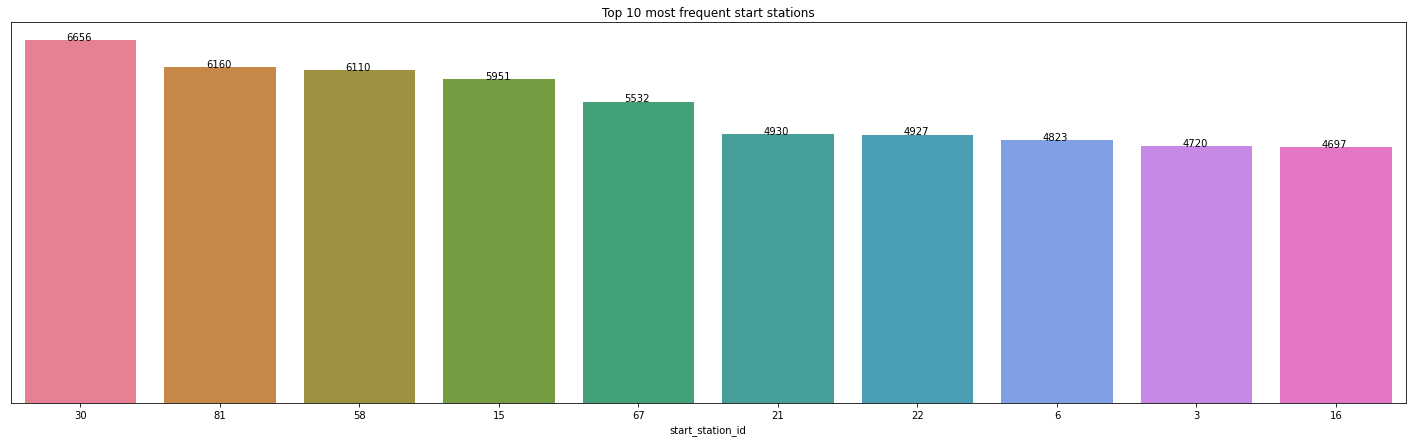

In [33]:
fig, ax = plt.subplots(figsize = (25,7))
ax = sns.countplot(x = "start_station_id", data = df, order=df.start_station_id.value_counts().iloc[:10].index, palette = "husl")
ax.set_title("Top 10 most frequent start stations");
ax.axes.get_yaxis().set_visible(False)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+2))

In [34]:
df.start_station_name.value_counts().iloc[:10]

San Francisco Caltrain (Townsend St at 4th St)               6656
Berry St at 4th St                                           6160
Market St at 10th St                                         6110
San Francisco Ferry Building (Harry Bridges Plaza)           5951
San Francisco Caltrain Station 2  (Townsend St at 4th St)    5532
Montgomery St BART Station (Market St at 2nd St)             4930
Howard St at Beale St                                        4927
The Embarcadero at Sansome St                                4823
Powell St BART Station (Market St at 4th St)                 4720
Steuart St at Market St                                      4697
Name: start_station_name, dtype: int64

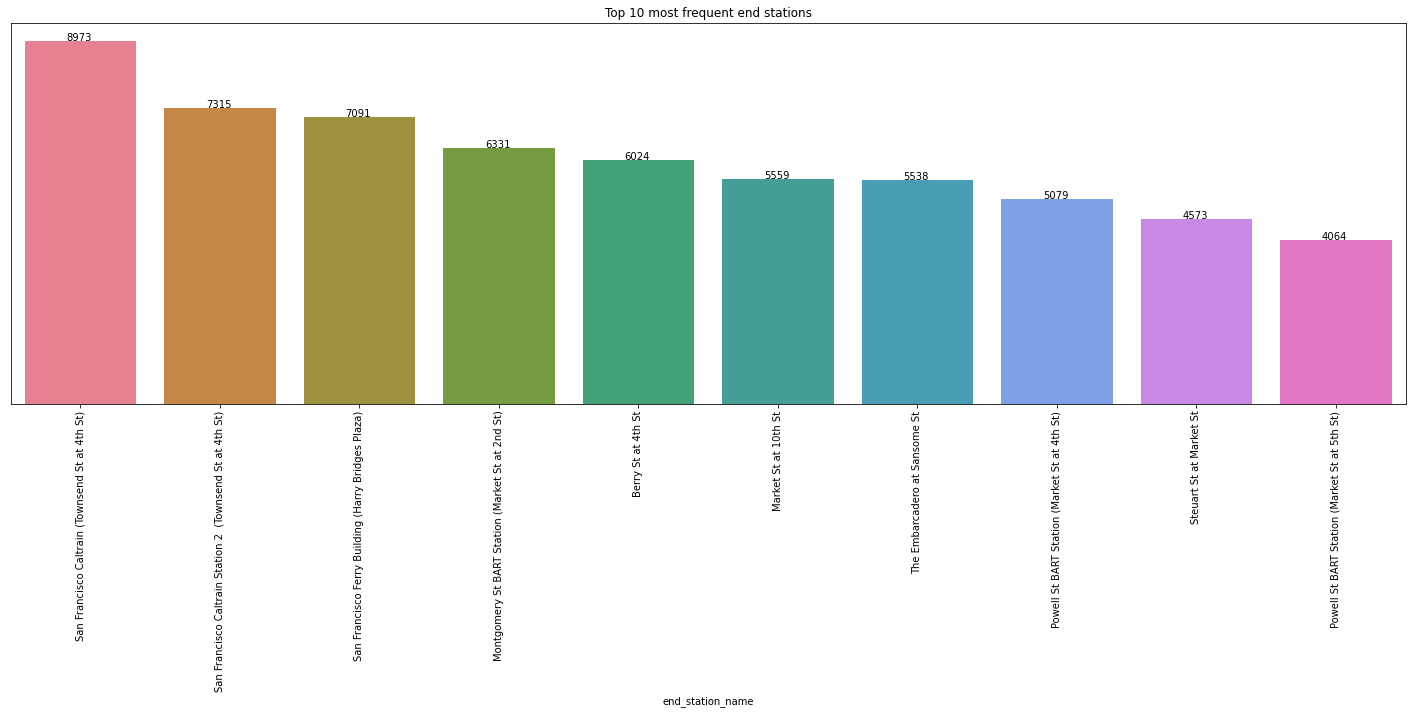

In [35]:
fig, ax = plt.subplots(figsize = (25,7))
ax = sns.countplot(x = "end_station_name", data = df, order=df.end_station_name.value_counts().iloc[:10].index, palette = "husl")
ax.set_title("Top 10 most frequent end stations");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.axes.get_yaxis().set_visible(False)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+2))

__San Francisco Caltrain (Townsend St at 4th St)__ is the most frequent start and end station. It is used as start station for 6656 times, while it was an end of a trip 8973 times. Similarly let us see, which are the least frequent start and end stations.

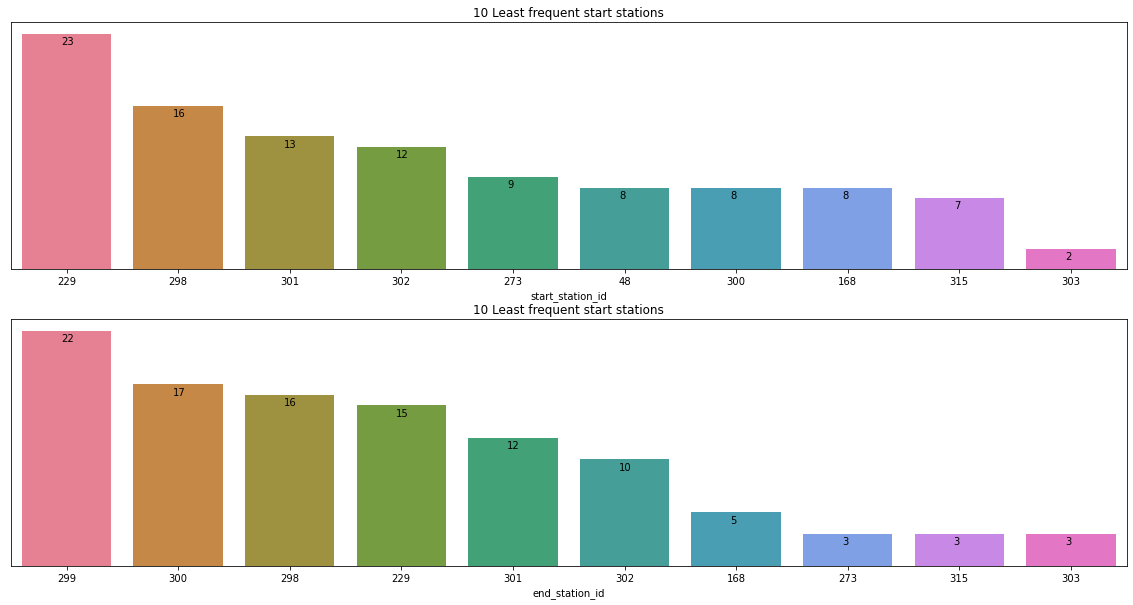

In [36]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=[20,10])

sns.countplot(x = "start_station_id", data = df, order=df.start_station_id.value_counts().iloc[-10:].index, ax=ax1, palette = "husl")
ax1.set_title("10 Least frequent start stations");
ax1.axes.get_yaxis().set_visible(False)
for p in ax1.patches:
    ax1.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()-1))
    
sns.countplot(x = "end_station_id", data = df, order=df.end_station_id.value_counts().iloc[-10:].index, ax=ax2, palette = "husl")
ax2.set_title("10 Least frequent start stations");
ax2.axes.get_yaxis().set_visible(False)
for p in ax2.patches:
    ax2.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()-1))

In [37]:
df.start_station_name.value_counts().iloc[-10:]

Foothill Blvd at 42nd Ave       23
Oak St at 1st St                16
Willow St at Vine St            13
Tamien Station                  12
Fulton St at Ashby Ave           9
2nd St at S Park St              8
Palm St at Willow St             8
Alcatraz Ave at Shattuck Ave     8
Market St at 45th St             7
San Pedro St at Hedding St       2
Name: start_station_name, dtype: int64

In [38]:
df.end_station_name.value_counts().iloc[-10:]

Bestor Art Park                 22
Palm St at Willow St            17
Oak St at 1st St                16
Foothill Blvd at 42nd Ave       15
Willow St at Vine St            12
Tamien Station                  10
Alcatraz Ave at Shattuck Ave     5
Fulton St at Ashby Ave           3
San Pedro St at Hedding St       3
Market St at 45th St             3
Name: end_station_name, dtype: int64

__San Pedro St at Hedding St__ was used as starting point only twice and __Fulton St at Ashby Ave__ was used as end station only 3 times

_**Question 2.2 : What are the busiest times of Day ?**_

Here, we can explore at what hour of day most of the trips start and end. As we have all the data from 1st three months of year 2018, let us see this data monthwise.


_**Answer 2.2 :**_

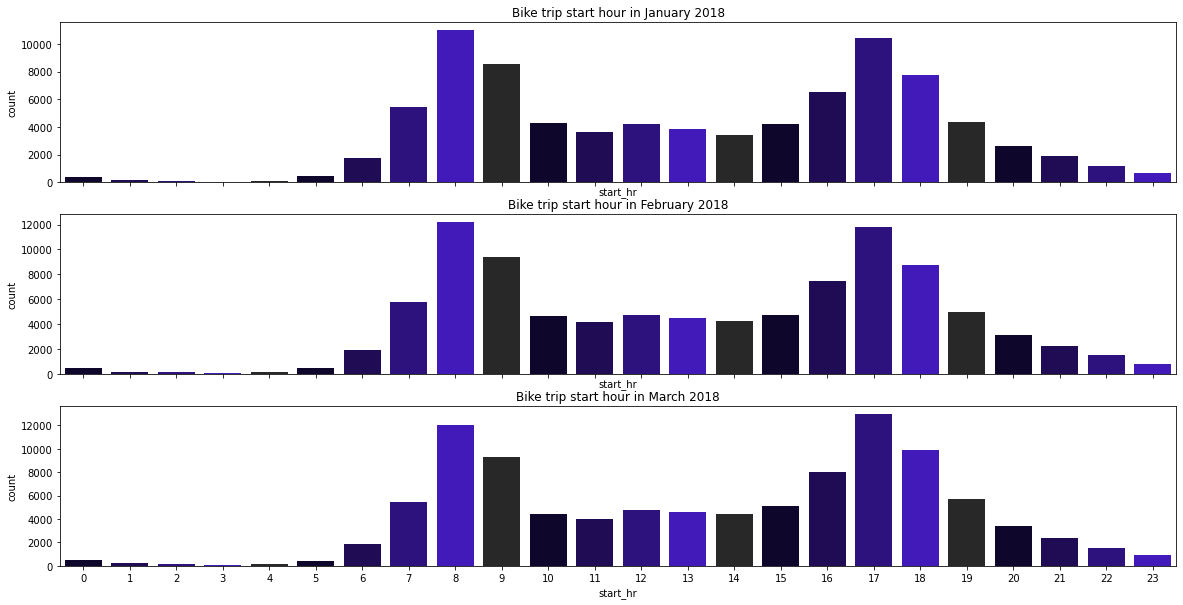

In [39]:
timep=["#0C0032","#190061","#240090","#3500D3","#282828"]

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[20,10], sharex=True)

sns.countplot(x = "start_hr", data = df.query("year_month == 1"), ax=ax1, palette = timep)
ax1.set_title("Bike trip start hour in January 2018");

sns.countplot(x = "start_hr", data = df.query("year_month == 2"), ax=ax2, palette = timep)
ax2.set_title("Bike trip start hour in February 2018");

sns.countplot(x = "start_hr", data = df.query("year_month == 3"), ax=ax3, palette = timep)
ax3.set_title("Bike trip start hour in March 2018");

Here is a pattern in Ford GoBike trip start hour. In all the three months, the most of the bike trips start at __8:00 am__ and at __05:00 pm__. This can be related to the office timings. It is quite possible that office going people use Ford GoBike service most often. 

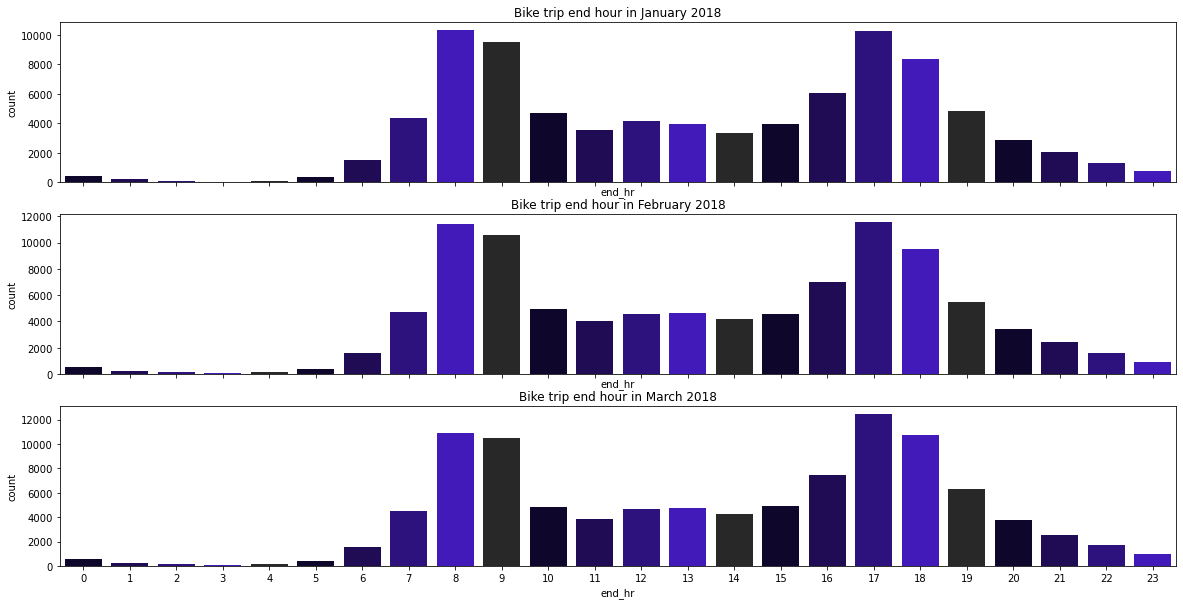

In [40]:
timep=["#0C0032","#190061","#240090","#3500D3","#282828"]

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[20,10], sharex=True)

sns.countplot(x = "end_hr", data = df.query("year_month == 1"), ax=ax1, palette = timep)
ax1.set_title("Bike trip end hour in January 2018");

sns.countplot(x = "end_hr", data = df.query("year_month == 2"), ax=ax2, palette = timep)
ax2.set_title("Bike trip end hour in February 2018");

sns.countplot(x = "end_hr", data = df.query("year_month == 3"), ax=ax3, palette = timep)
ax3.set_title("Bike trip end hour in March 2018");

Similar to the start hour, the end time for most of the trips in any month was __08:00 am__ and __05:00 pm__. This gives rise to the question about bike share duration. If most of the trips start and end in the same hour, the _average of the duration must be less than 1 hour_. Let us quickly check this.

In [41]:
df.duration_sec.mean()

739.4751298899755

The average duration of the trip is 739.5 sec i.e. approximately 12 minutes. This observation is inline with above 2 plots.

**_Question 2.3: Which one is the favorite day for Bikers ?_**

The day which appeared maximum number of times in this dataset can be determined here. 

**_Answer 2.3:_**

This can be done with simple countplot in seaborn library. The occurance of a particular day in the dataset will be counted for this.


Text(0.5, 1.0, 'Favorite day for Bikers')

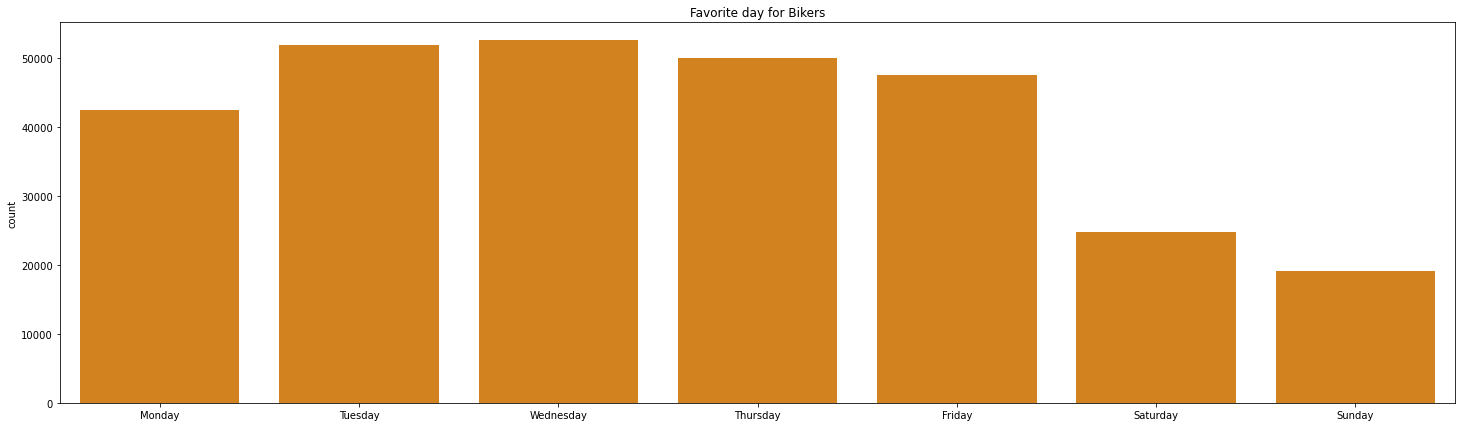

In [42]:
fig, ax = plt.subplots(figsize = (25,7))
ax = sns.countplot(x = "dayofweek", data = df, color="#F08500")
ax.set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
ax.set_xlabel("")
ax.set_title("Favorite day for Bikers")

_**Question 2.4 : What is the distribution of GoBike share duration in three clusters of GoBike stations ?**_
    
The duration for which the bike is shared when the trip starts from a particular station, can be found with the help of histograms.

_**Answer 2.4 :**_

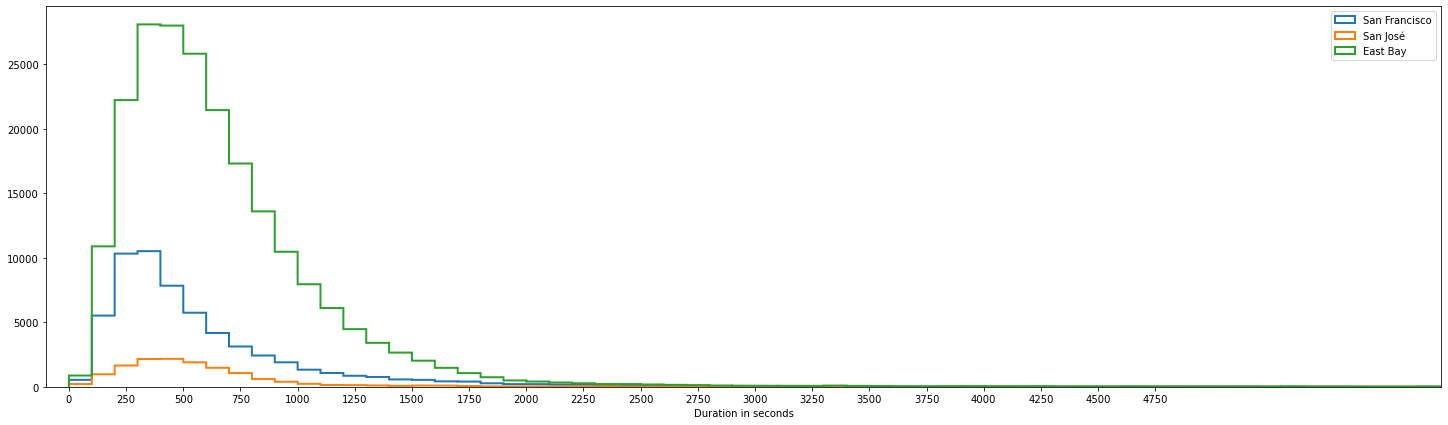

In [43]:
fig, ax = plt.subplots(figsize = (25,7))
for x in mapping.values():
    df_new = df_start.query(f"label_name == '{x}'")
    bin_size = 100
    bins = np.arange(0,df_new.duration_sec.max()+bin_size,bin_size)   
    plt.hist(df_new.duration_sec, bins = bins, label = x, histtype='step', linewidth = 2);
    
plt.xticks(ticks = [x for x in range(0,5000,250)])
plt.legend()
plt.xlabel("Duration in seconds")
plt.xlim(-100,6000);
del df_new

Above histogram shows that, maximum trips starting in the San Francisco region have duration of approximately 500 seconds. However, the maximum trips starting in East Bay and San Jose region have duration smaller than 500 seconds.

The distribution of trip duration is identical in all the three clusters of GoBike stations as all the three histograms are right skewed.

_**Question 2.5 : What different types of users were using Ford GoBike ?**_

The different types of user such as male or female and subscriber or customer can be explored to answer this question.

_**Answer 2.5:**_

The gender-wise GoBike usage can be explored here.

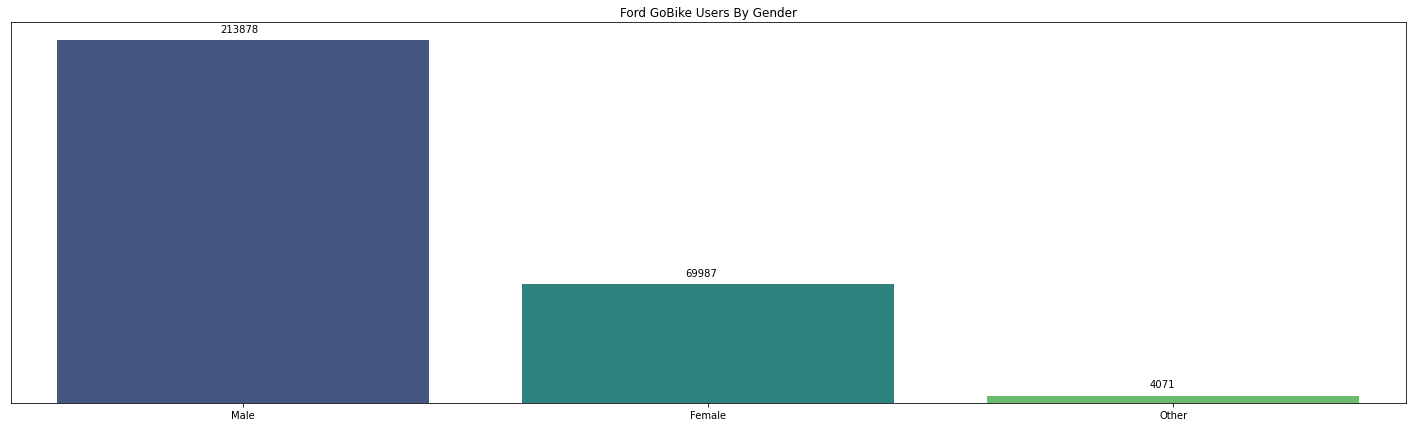

In [44]:
fig, ax = plt.subplots(figsize = (25,7))
sns.countplot(x = "member_gender", data = df,  order=df.member_gender.value_counts().index, palette = "viridis");
ax.axes.get_yaxis().set_visible(False)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+5000))

plt.title("Ford GoBike Users By Gender");
plt.xlabel("");

**Number of female users are almost 1/3rd of number of male users.**

Also, the user can be differentiated depending on its type -- subscriber or customer

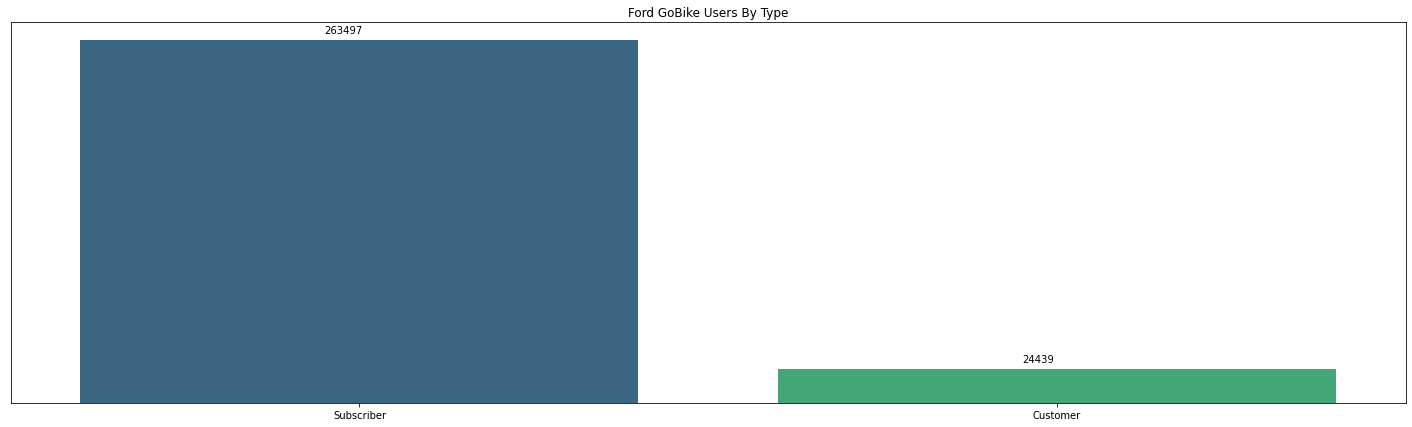

In [45]:
fig, ax = plt.subplots(figsize = (25,7))
sns.countplot(x = "user_type", data = df, order=df.user_type.value_counts().index, palette = "viridis");
ax.axes.get_yaxis().set_visible(False)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+5000))
plt.title("Ford GoBike Users By Type");
plt.xlabel("");

Almost 90% Ford GoBike users are subscribers, while remaining only 24,439 users are customers.

_**Question 2.6 : What are the different user types in the clusters of GoBike stations ?**_

The number of subscribers and customers in the different station clusters can be explored in the below graphs.

_**Answer 2.6 :**_

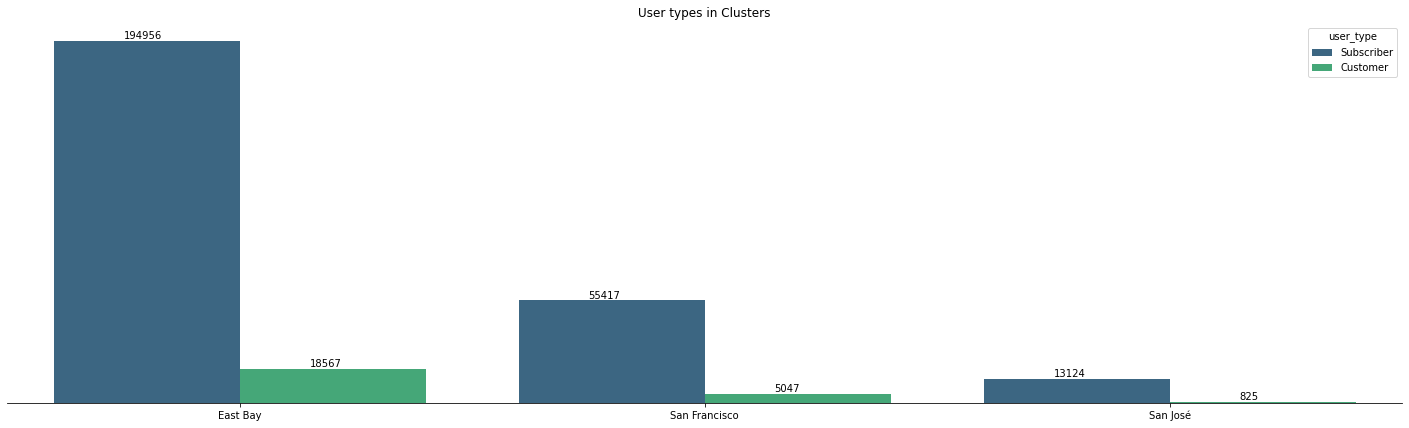

In [46]:
fig, ax = plt.subplots(figsize = (25,7))
sns.countplot(x = "label_name", data = df_start, order=df_start.label_name.value_counts().index, palette = "viridis", hue = "user_type");
ax.axes.get_yaxis().set_visible(False)
sns.despine(fig, left = True)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1000))

plt.title("User types in Clusters");
plt.xlabel("");

There are more number of subscribers in all the three clusters. Almost 90% of users in any cluster are subscribers.

_**Question 2.7 : What is the distribution of age of the users in entire dataset ?**_

This question will be answered using below bar chart.

_**Answer 2.7 :**_

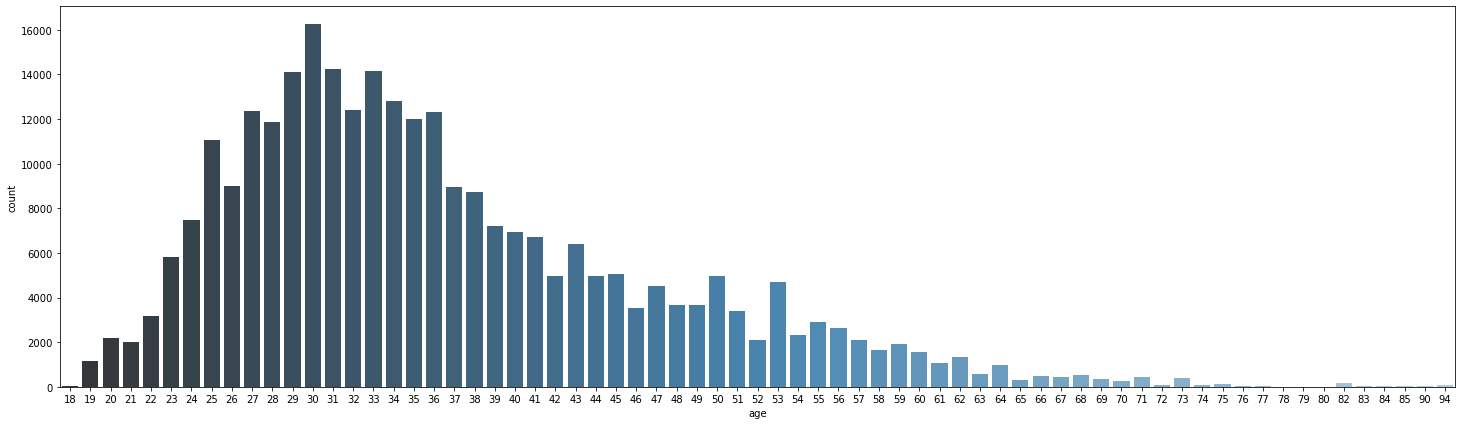

In [47]:
fig, ax = plt.subplots(figsize = (25,7))
sns.countplot(x = "age", data = df.query("age < 100").sort_values("age"), orient = "h", palette = "Blues_d");

In [ ]:
df.age.mean()

The average age of user is 36.5 years with maximum users of age 30.

The number users of age more than 60 years is fewer than 2000 and the youngest user is of 18 years old.

>_**To sum up the Univariate Exploration** here are the key insights obtained from it_

1. San Francisco Caltrain (Townsend St at 4th St) is the most frequent start and end station. It is used as end station more number of times than as start station.


2. 08:00 O'clock in the morning and 05:00 O'clock in the evening is found to be busiest time in a day. Moderate number of trips were recorded between 08:00 am and 05:00 pm, however, low number of trips occured beyond this time window. The trend is similar during all the first 3 months of 2018.


3. As compared to female members, more number of male members used Ford GoBike system. Also, there are more number of subscribers than the customers. 


4. Looking at the location clusters, _San Francisco_ seems to be popular among all, such that, 75% of people start their journey at _San Francisco_. Also, this cluster has highest number of trips of any duration as compared to East Bay and San Jose.


5. 72 % of Ford GoBike system users are people younger than 40 years age. Maximum number of people are of 30 years. 

-----------------------------------------------------------------------------------------------------------------

### 3. Bivariate Exploration

In this section, the relationships between 2 different variables in the data will be explored. In this process again, few questions will be posed and answered.

_**Question 3.1 : What are the top 10 most frequently used routes ?**_

A route is defined as combination of _a start station to a end station_. For this, let us create a new dataframe called as <code>df_route</code>

_**Answer 3.1 :**_

A new column called as _bikeroute_ will be added to the existing dataframe where start and end station id will be joined together to make different routes. 

In [48]:
df_route = df.copy()
df_route.head(3)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,age,year_month,dayofweek,start_hr,end_hr
0,75284,2018-01-31 22:52:35.239,2018-02-01 19:47:19.824,120,Mission Dolores Park,37.761420,-122.426435,285,Webster St at O'Farrell St,37.783521,...,2765,Subscriber,1986,Male,No,32,1,2,22,19
1,71576,2018-01-31 14:23:55.889,2018-02-01 10:16:52.116,304,Jackson St at 5th St,37.348759,-121.894798,296,5th St at Virginia St,37.325998,...,3039,Customer,1996,Male,No,22,1,2,14,10
2,39966,2018-01-31 19:52:24.667,2018-02-01 06:58:31.053,74,Laguna St at Hayes St,37.776435,-122.426244,19,Post St at Kearny St,37.788975,...,617,Subscriber,1991,Male,No,27,1,2,19,6


In [49]:
df_route.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287936 entries, 0 to 287935
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             287936 non-null  int64         
 1   start_time               287936 non-null  datetime64[ns]
 2   end_time                 287936 non-null  datetime64[ns]
 3   start_station_id         287936 non-null  int64         
 4   start_station_name       287936 non-null  object        
 5   start_station_latitude   287936 non-null  float64       
 6   start_station_longitude  287936 non-null  float64       
 7   end_station_id           287936 non-null  int64         
 8   end_station_name         287936 non-null  object        
 9   end_station_latitude     287936 non-null  float64       
 10  end_station_longitude    287936 non-null  float64       
 11  bike_id                  287936 non-null  int64         
 12  user_type       

In [50]:
for col in ["start_station_id", "end_station_id"]:
    df_route[col] = df_route[col].astype("str")

In [51]:
df_route.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287936 entries, 0 to 287935
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             287936 non-null  int64         
 1   start_time               287936 non-null  datetime64[ns]
 2   end_time                 287936 non-null  datetime64[ns]
 3   start_station_id         287936 non-null  object        
 4   start_station_name       287936 non-null  object        
 5   start_station_latitude   287936 non-null  float64       
 6   start_station_longitude  287936 non-null  float64       
 7   end_station_id           287936 non-null  object        
 8   end_station_name         287936 non-null  object        
 9   end_station_latitude     287936 non-null  float64       
 10  end_station_longitude    287936 non-null  float64       
 11  bike_id                  287936 non-null  int64         
 12  user_type       

In [52]:
df_route["bikeroute"] = df_route["start_station_id"] + "-" + df_route["end_station_id"]
df_route.sample(3)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,user_type,member_birth_year,member_gender,bike_share_for_all_trip,age,year_month,dayofweek,start_hr,end_hr,bikeroute
197573,641,2018-03-28 19:48:57.796,2018-03-28 19:59:39.123,86,Market St at Dolores St,37.769305,-122.426826,41,Golden Gate Ave at Polk St,37.78127,...,Subscriber,1983,Female,No,35,3,2,19,19,86-41
84130,175,2018-01-02 16:39:52.675,2018-01-02 16:42:47.814,24,Spear St at Folsom St,37.789677,-122.390428,16,Steuart St at Market St,37.79413,...,Subscriber,1975,Male,No,43,1,1,16,16,24-16
175387,307,2018-02-03 15:50:54.915,2018-02-03 15:56:02.089,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,26,1st St at Folsom St,37.78729,...,Customer,1990,Male,No,28,2,5,15,15,284-26


In [53]:
df_route.bikeroute.value_counts().head(10)

15-6       1238
81-15       954
6-16        952
182-196     842
15-81       792
21-49       766
196-182     752
195-182     691
58-67       657
6-15        629
Name: bikeroute, dtype: int64

The route with start station id 15 and end station id 6 is the most frequent route.

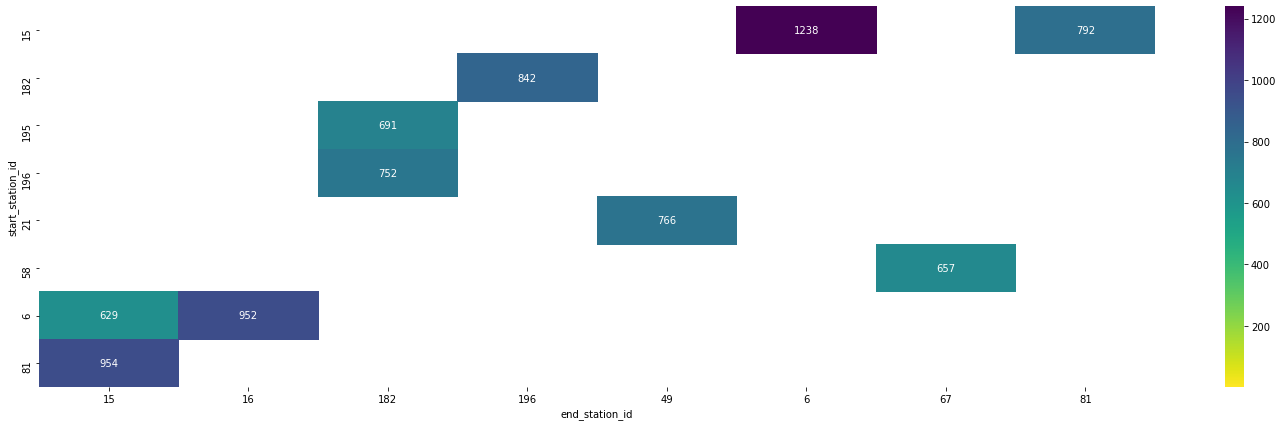

In [54]:
routelist = df_route.bikeroute.value_counts().head(10).keys()
df_criteria = df_route[df_route["bikeroute"].isin(routelist)]
df_pivot = df_criteria.pivot_table(index="start_station_id", columns = "end_station_id", values = "start_time", aggfunc = "count", fill_value = 0)
fig, ax = plt.subplots(figsize = (25,7))
sns.heatmap(df_pivot, annot = True, cmap = "viridis_r", fmt='g', vmin = 1, vmax = 1240, mask= df_pivot == 0)

In [55]:
pd.set_option('display.max_colwidth', 4000)
df_route[df_route["start_station_id"] == "15"]["start_station_name"]

25        San Francisco Ferry Building (Harry Bridges Plaza)
81        San Francisco Ferry Building (Harry Bridges Plaza)
130       San Francisco Ferry Building (Harry Bridges Plaza)
352       San Francisco Ferry Building (Harry Bridges Plaza)
446       San Francisco Ferry Building (Harry Bridges Plaza)
                                 ...                        
287824    San Francisco Ferry Building (Harry Bridges Plaza)
287825    San Francisco Ferry Building (Harry Bridges Plaza)
287838    San Francisco Ferry Building (Harry Bridges Plaza)
287871    San Francisco Ferry Building (Harry Bridges Plaza)
287880    San Francisco Ferry Building (Harry Bridges Plaza)
Name: start_station_name, Length: 5951, dtype: object

In [56]:
df_route[df_route["end_station_id"] == "6"]["end_station_name"]

25        The Embarcadero at Sansome St
81        The Embarcadero at Sansome St
433       The Embarcadero at Sansome St
442       The Embarcadero at Sansome St
467       The Embarcadero at Sansome St
                      ...              
287711    The Embarcadero at Sansome St
287750    The Embarcadero at Sansome St
287786    The Embarcadero at Sansome St
287824    The Embarcadero at Sansome St
287838    The Embarcadero at Sansome St
Name: end_station_name, Length: 5538, dtype: object

Above heatmap also highlights the route 15-6 i.e. route from _San Francisco Ferry Building (Harry Bridges Plaza)_ to _The Embarcadero at Sansome St_ is the most frequently used route.

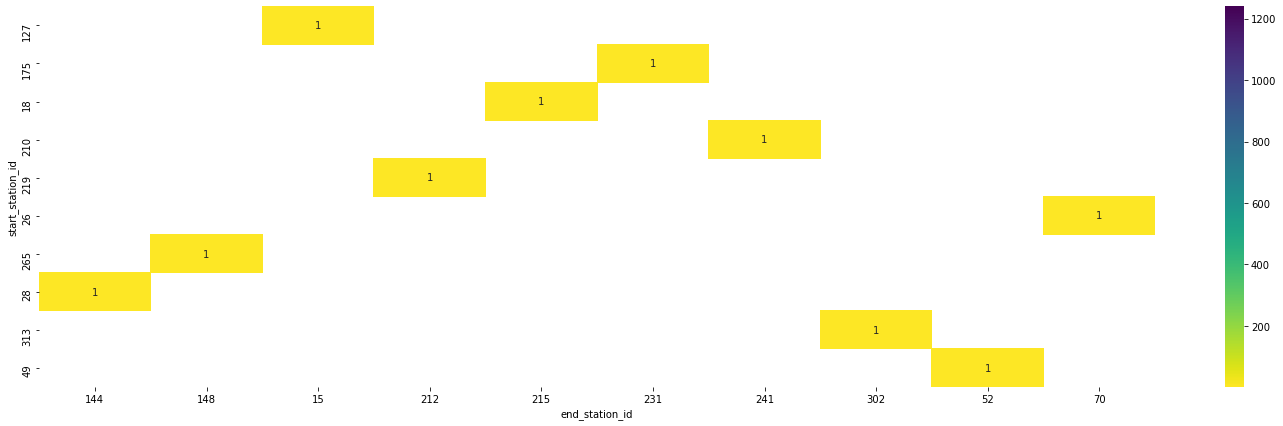

In [57]:
routelist = df_route.bikeroute.value_counts().tail(10).keys()
df_criteria = df_route[df_route["bikeroute"].isin(routelist)]
df_pivot = df_criteria.pivot_table(index="start_station_id", columns = "end_station_id", values = "start_time", aggfunc = "count", fill_value = 0)
fig, ax = plt.subplots(figsize = (25,7))
sns.heatmap(df_pivot, annot = True, cmap = "viridis_r", fmt='g', vmin = 1, vmax = 1240, mask= df_pivot == 0)

Similarly, above heatmap shows **least frequent** routes which are used only once.

Additionally below visualization shows the different routes and how frequently those are used.

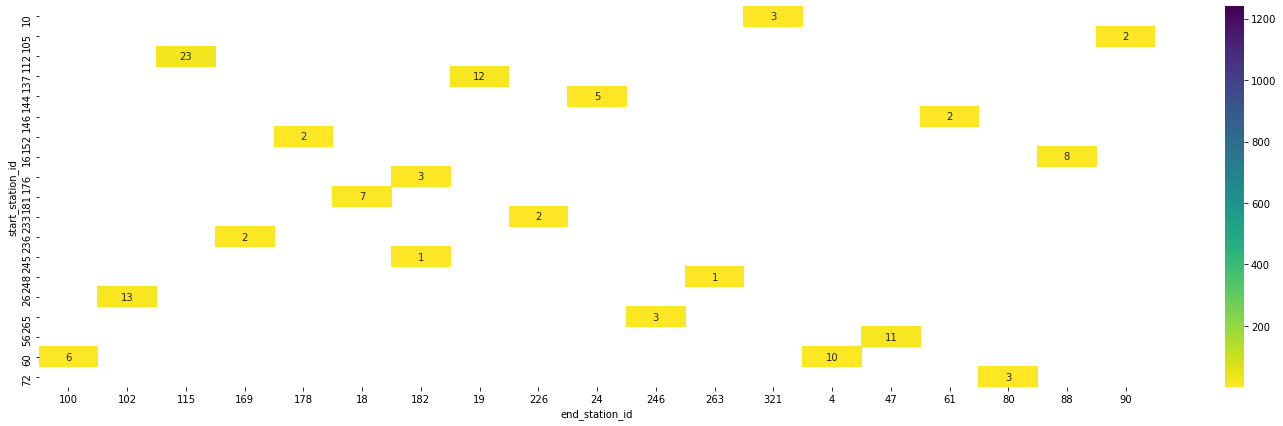

In [58]:
routelist = df_route.bikeroute.value_counts().sample(20, random_state=7).keys()
df_criteria = df_route[df_route["bikeroute"].isin(routelist)]
df_pivot = df_criteria.pivot_table(index="start_station_id", columns = "end_station_id", values = "start_time", aggfunc = "count", fill_value = 0)
fig, ax = plt.subplots(figsize = (25,7))
sns.heatmap(df_pivot, annot = True, cmap = "viridis_r", fmt='g', vmin = 1, vmax = 1240, mask= df_pivot == 0)

As this project was done over few days, it is better to store the dataframe as pickle file.

>df.to_pickle("./main_df.pkl")

>df_route.to_pickle("./route_df.pkl")

before working on project next time, we can directly start with importing these pickle files

>df = pd.read_pickle("./main_df.pkl")

>df_route = pd.read_pickle("./route_df.pkl")

_**Question 3.2: The distribution of Ford GoBike trip duration per day ?**_

Through this question, another interesting relationship between the variables <code>dayofweek</code> and <code>duration_sec</code> can be explored. This will give us insights into the average duration of a trip on different days of week.

_**Answer 3.2:**_

Let us first explore the relationship through boxplot and then can discuss about this exploration.
    


Text(0, 0.5, 'Average trip duration in seconds')

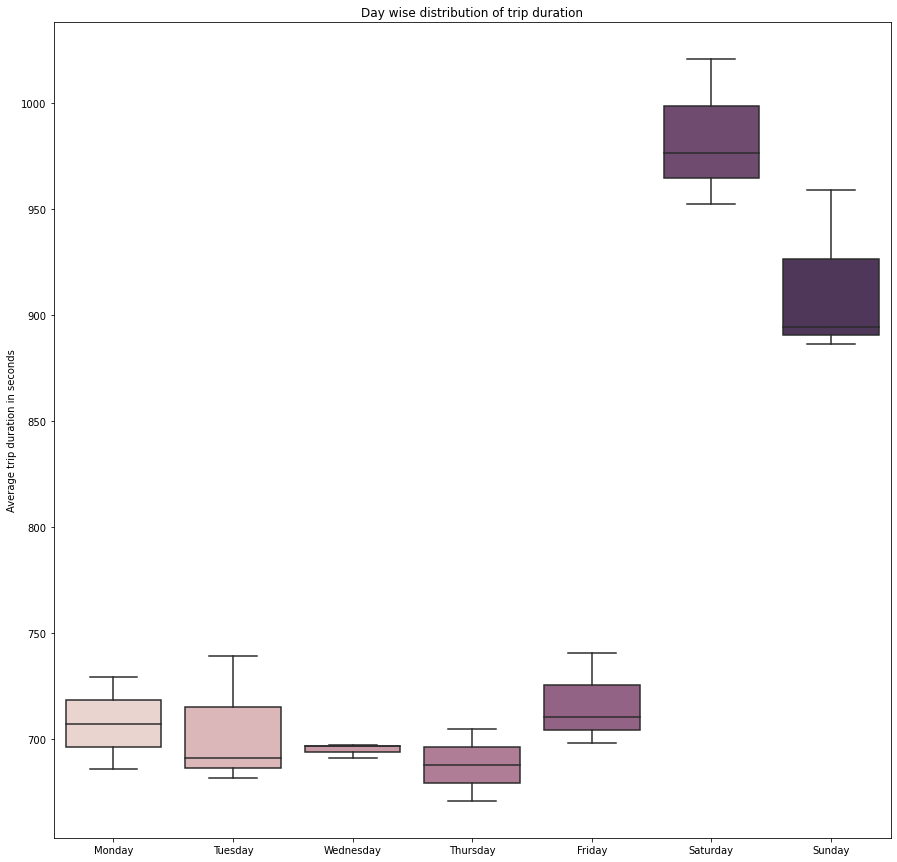

In [80]:
fig, ax = plt.subplots(figsize = (15,15))
ax = sns.boxplot(x = "dayofweek", y = "duration_sec", data = df.groupby(["dayofweek", "year_month"], as_index = False).mean(), palette = sns.cubehelix_palette(8))
ax.set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
ax.set_title("Day wise distribution of trip duration")
ax.set_xlabel("")
ax.set_ylabel("Average trip duration in seconds")

The above boxplot shows that the variation of average trip duration per day. Clearly there is some relationship between these two variable and can be discussed as whether it is a weekday or weekend.

The average trip duration stays around 700 seconds i.e. approximately 12 minutes on weekdays. However, on weekends this average duration shoots up to around 900 to 1000 seconds. 

Talking in terms of IQR (Inter-Quartile Range), the lowest IQR is observed on the Wednesday while the maximum IQR can be observed on weekends i.e. on Saturday and Sunday. In real world scenario the IQR can be understood as variation in data. So, on Wednesday, there is very less variation in the trip duration, whereas on weekends there is huge variation in the trip durations. 

_**Question 3.3: Distribution of Ford GoBike trip duration as per age ?**_ 

Just similar to the previous question, I am being curious, whether there is any relationship between <code>age</code> and <code>duration_sec</code> variables.

_**Answer 3.3:**_

Whether the duration of bike hire changes as per the age of the user or not, can be explored through this visualization.

To visualize the age wise distribution, it is good idea to divide the user ages in different groups i.e. bins. Let us make a new dataframe as copy of <code>df_route</code> and name it as <code>df_userage</code>. Only the users of and below 60 years of age will be selected.

In [89]:
df_userage = df_route.query("age < 61").copy()
df_userage.shape

(279841, 22)

In [90]:
agegroups = [x for x in range(10,61,10)] # making the groups 10 years range
df_userage["age_groups"] = pd.cut(df_userage.age, bins = agegroups, precision = 0, include_lowest=False)

In [91]:
df_userage[["age", "age_groups"]].head(10)

,age,age_groups
0,32,"(30, 40]"
1,22,"(20, 30]"
2,27,"(20, 30]"
3,30,"(20, 30]"
4,38,"(30, 40]"
5,31,"(30, 40]"
6,24,"(20, 30]"
7,25,"(20, 30]"
9,42,"(40, 50]"
10,42,"(40, 50]"


Looks good ! Everything worked well. each user is now alloted to a age group.

Now let us proceed with the visualization.

Text(0, 0.5, 'Average trip duration in seconds')

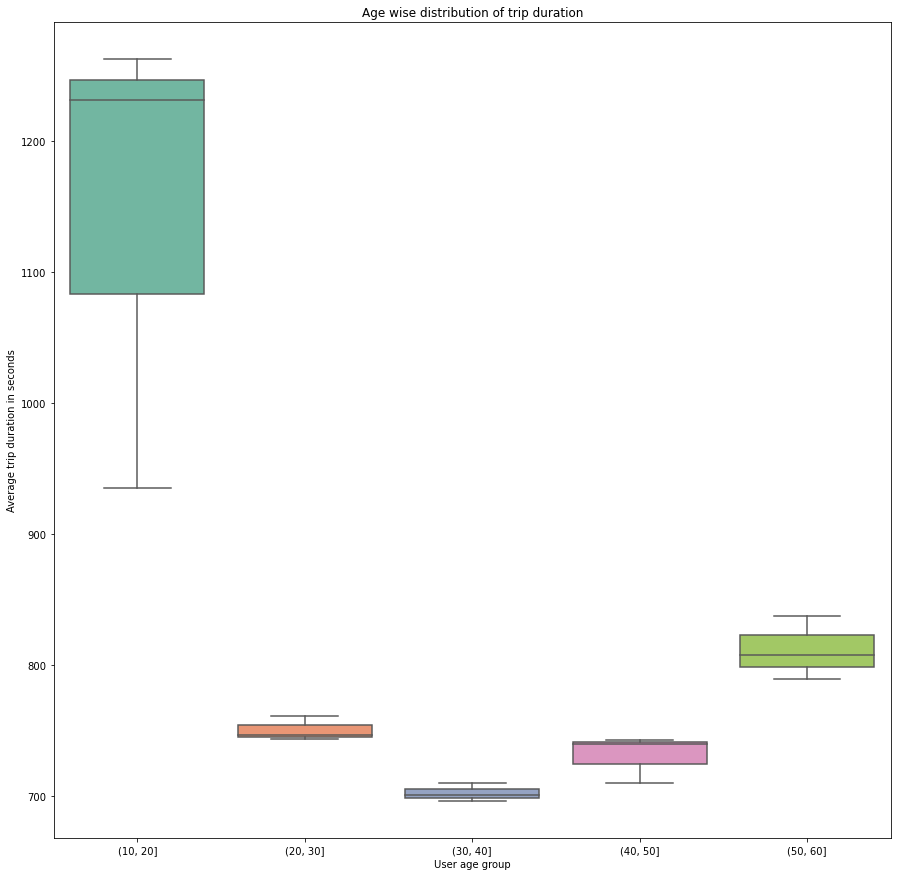

In [104]:
fig, ax = plt.subplots(figsize = (15,15))
ax = sns.boxplot(x = "age_groups", y = "duration_sec", data = df_userage.groupby(["age_groups","year_month"], as_index = False).mean(), palette = "Set2")
ax.set_title("Age wise distribution of trip duration")
ax.set_xlabel("User age group")
ax.set_ylabel("Average trip duration in seconds")

Ford GoBike riders of age group 10 to 20, use bike for longer duration as seen in the above boxplot. The people in age group 30 to 40 years old, resulted in smaller duration of trip. 

The trip duration shows decreasing trend as we increase the age upto 40 years old and then duration starts increasing again beyond this age group. This trend is quite relatable. It is possible that, teens yonger than 20 years old can use the Bike just for playing and roaming around the city. Also, the people older than 50 years age take longer time for trip may be due to physical limitations. However, the people in 20 to 40 years old, are usually working or studying. Hence, they use this Bike as a service or transport option and hence take minimum trip time.

No robust data is available about this, hence this is just the possibility.

>_**To sum up the Bivariate Exploration** here are the key insights from it..._

1. The route connecting _San Francisco Ferry Building (Harry Bridges Plaza)_ to _The Embarcadero at Sansome St_ is the most frequently used route


2. The average GoBike trip duration on weekends is higher than that of on weekdays. The trip duration varies largely on weekends, whereas lowest variation in trip duration is observed on wednesday


3. The average GoBike trip duration decreases with increase in the age of the user. This trend continues till the age group (30,40]. Beyond this stage, the average trip duration starts increasing again.

---------------------------------------------------------------------------------------------

### 4. Multivariate Exploration

relationships between more than two variables can be explored using multivariate plots.

_**Question 4.1: How does the trip duration distributed over start and end time of the trip ?**_

To answer this question, _start_hr, end_hr, duration_sec_ variable will be considered

_**Answer 4.2:**_


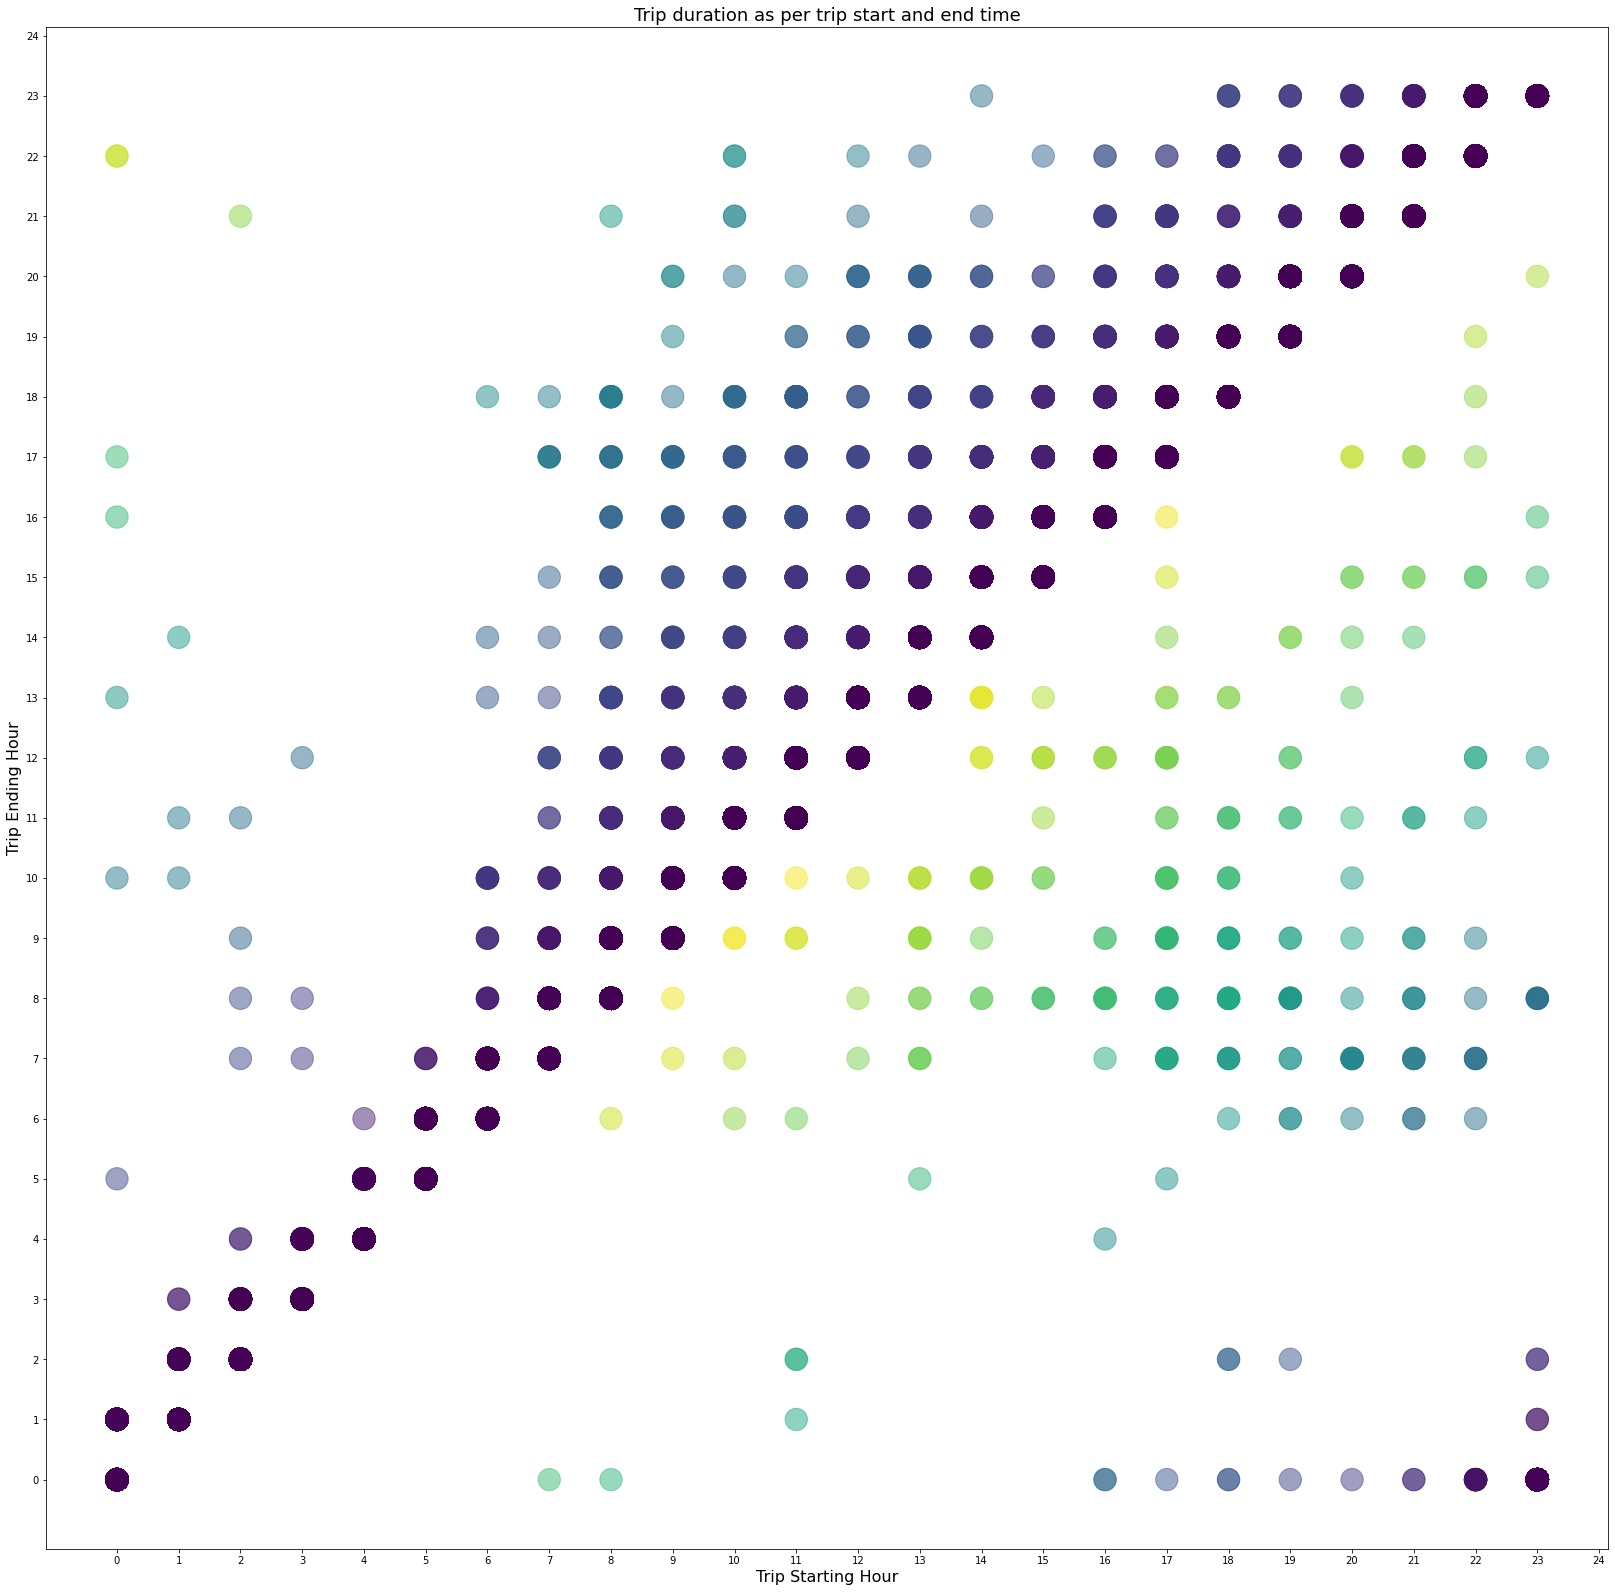

In [195]:
fig, ax = plt.subplots(figsize = (28,28))
plt.scatter(x="start_hr", y="end_hr", c="duration_sec", s=500, data=df_userage, alpha=0.5)
ax.set_xticks(np.arange(0, 25, step=1));
ax.set_yticks(np.arange(0, 25, step=1));
ax.set_xlabel("Trip Starting Hour", fontsize=16);
ax.set_ylabel("Trip Ending Hour", fontsize=16);
ax.set_title("Trip duration as per trip start and end time", fontsize=18);

with the help of above graph, the variation of trip duration is visualized at different times of day. The start and end times of trip are plotted on x- and y-axis respectively and the color of markers is changes according to trip duration. Hence, ultimately visualizing the relationship between three variables. The transparency value of 0.2 is considered so that the markers which are dark denotes overlapping of multiple markers.

The darker pattern along the diagonal of the above graph highlights one of the result from univariate exploration, such that, most of of the trips start and end within the same hour. As we move away from the diagonal, lighter markers can be observed, which means that, there were few trips with long durations.

_**Question 4.2: Is there any relationship between day of week, age group and duration of trip ?**_

Let us try to explore, if there is any trend in these variables.

_**Answer 4.2:**_

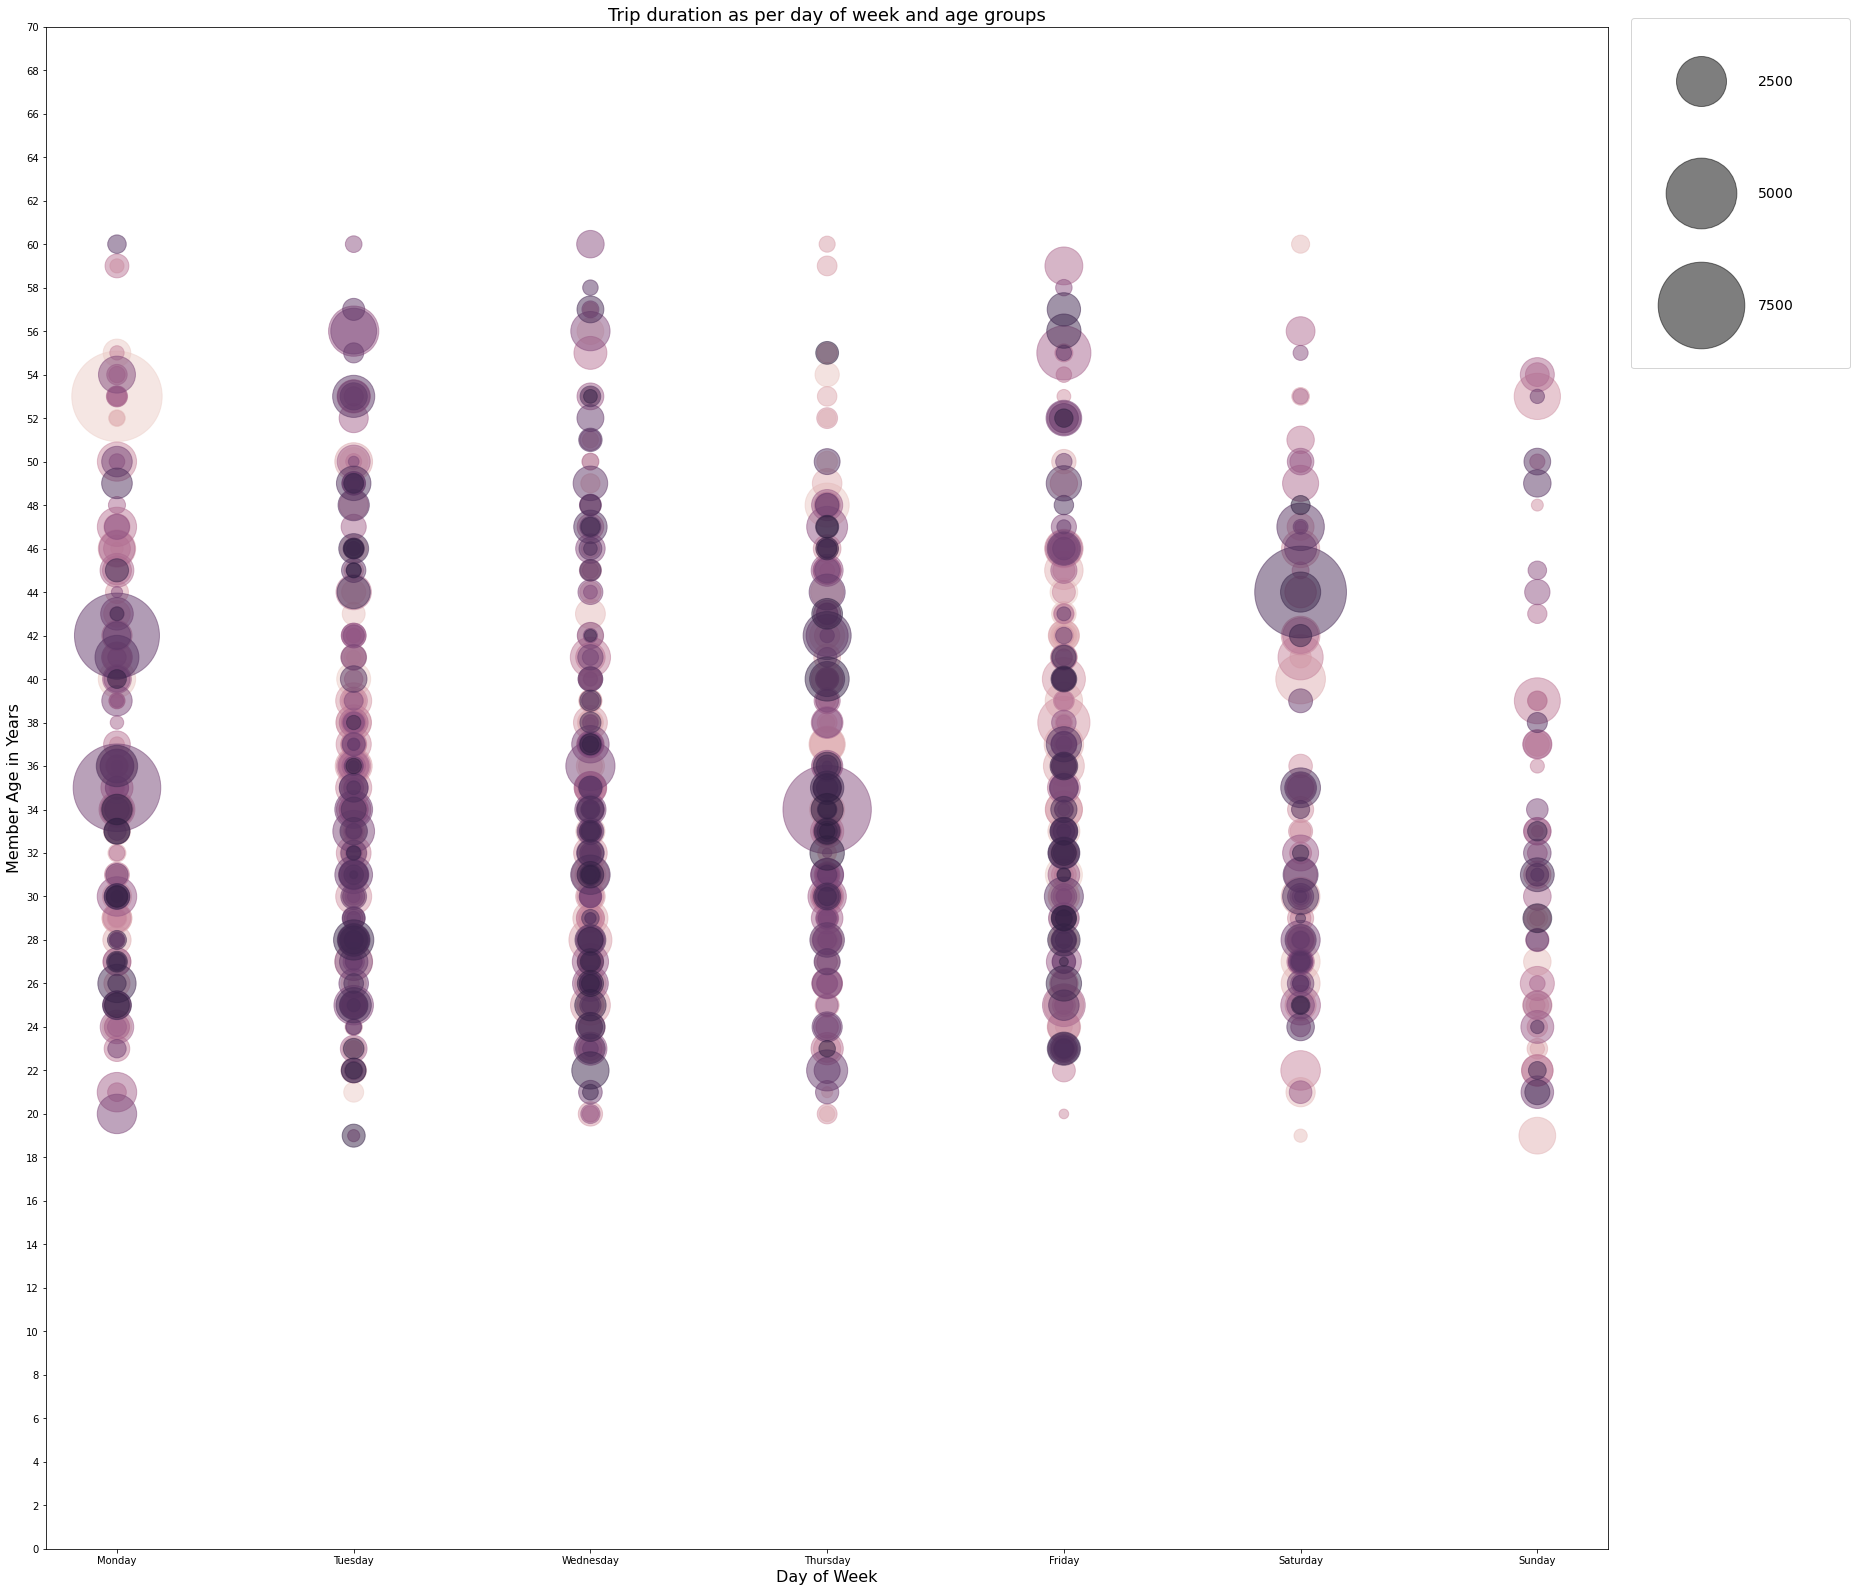

In [337]:
fig, ax = plt.subplots(figsize = (28,28))
sc = plt.scatter(x="dayofweek", y="age", s="duration_sec", c=sns.cubehelix_palette(1000), data=df_userage.sample(1000, random_state=15), alpha=0.5)
ax.set_xticks(np.arange(0, 7, step=1));
ax.set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
ax.set_yticks(np.arange(0, 71, step=2));
ax.set_xlabel("Day of Week", fontsize=16);
ax.set_ylabel("Member Age in Years", fontsize=16);
ax.set_title("Trip duration as per day of week and age groups", fontsize=18);
plt.legend(*sc.legend_elements("sizes", num=4),borderpad=4, loc='upper left',bbox_to_anchor=(1.01, 1.01), labelspacing=7, fontsize = 14, handletextpad=3)


In [273]:
df_userage.sample(1000, random_state=15).dayofweek.value_counts()

1    204
2    194
3    162
4    160
0    140
5     84
6     56
Name: dayofweek, dtype: int64

In order to explore these variables together, days of week and age are plotted on x- and y-axis. The third variable i.e. duration of trip is visualized in terms of marker size. The transparency value of 0.2 is considered so that the markers which are dark denotes overlapping of multiple markers. Here, darker the marker, more number of occuranced of particular datapoint.

No any relationship was observed between _dayofweek, duration_sec, age_ variables.

However, if samples of the data are collected and visualized then we can conclude something about that particular sample. For example, in above plot a random sample of 1000 rows is visualized. For this particular sample, people of age 32, 35, 42 and 44 years, use the bike for longer duration i.e. for 7500 seconds on Monday, Thursday and Saturday. 

On Sunday, almost all the markers are light in color, denotes that very few i.e. only 56 out of 1000 members in this sample use Ford GoBike service on Sunday and most of these people use the bike for time less than 2500 seconds.

>_**To sum up the Multivariate Exploration** here are the key insights from it..._

1. Most of trips start and end within the same hour resulting in average trip duration less than 1 hour. The GoBike trips with duration longer than 70000 seconds or 19 hours are started between 09:00 am and 05:00 pm.


2. No any relationship among _dayofweek, duration_sec_ and _age_ variables is observed.

### Conclusion

Ford GoBike System data for January, February and March 2018 is analysed. With the help of Univariate explorations, individual variables in the data are explored, while using Bivariate explorations relationships between different pairs of two variables are explored and visualized. At the end Multivariate explorations are used to unlock the trends and patterns in the data. 

Apart from these, the data had 3 inherent clusters based on the locations of Ford GoBike stations. With the help of K-Means clustering, the lables for these clusters are calculated and the <code>folium</code> package is used to visualize these location clusters on the actual map.

To conclude, below are the findings from this Exploratory Data Analysis of Ford GoBike System Data...

1. San Francisco Caltrain (Townsend St at 4th St) is the most frequent start and end station. It is used as end station more number of times than as start station.


2. The route connecting _San Francisco Ferry Building (Harry Bridges Plaza)_ to _The Embarcadero at Sansome St_ is the most frequently used route


3. 08:00 O'clock in the morning and 05:00 O'clock in the evening is found to be busiest time in a day. Moderate number of trips were recorded between 08:00 am and 05:00 pm, however, low number of trips occured beyond this time window. The trend is similar during all the first 3 months of 2018.


4. Most of trips start and end within the same hour resulting in average trip duration less than 1 hour.


5. As compared to female members, more number of male members used Ford GoBike system. Also, there are more number of subscribers than the customers. 


6. The average GoBike trip duration on weekends is higher than that of on weekdays. The trip duration varies largely on weekends, whereas lowest variation in trip duration is observed on wednesday


7. The average GoBike trip duration decreases with increase in the age of the user till 40 years old, beyond which the trip duration shows increasing trend again. 


Selective key insights are communicated through Explanatory Visualizations slide deck.



---------------------------------------------------------------------------------------

## Thank You !!!